In [1]:
%matplotlib notebook

-------start--------------
********/Users/astro/Documents/notebooks/zs/result/stackfits/10001-12701.fits************
10001-12701


<IPython.core.display.Javascript object>


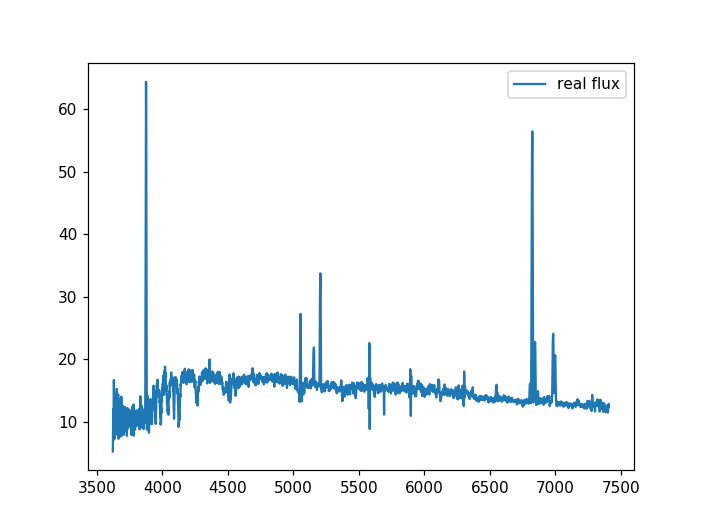

<IPython.core.display.Javascript object>


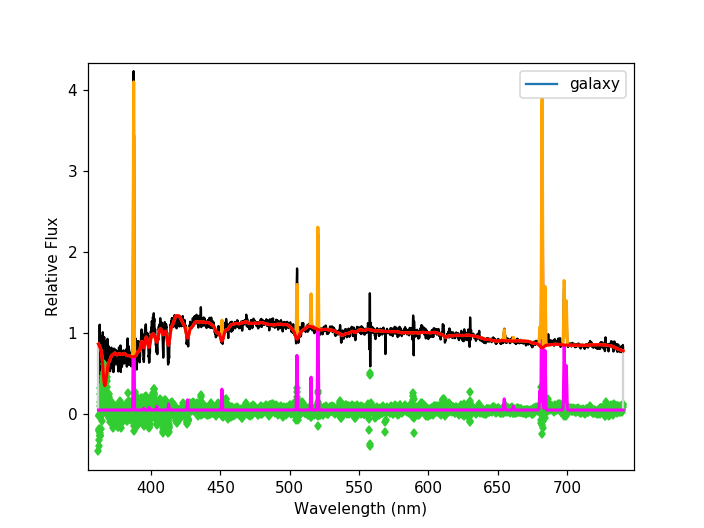

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[SII]6716' '[SII]6731' '[OIII]5007_d'
 '[OI]6300_d' '[NII]6583_d']
Weighted <logAge> [yr]: 9.96
Weighted <[M/H]>: -0.109
M/L_r: 2.509


<IPython.core.display.Javascript object>


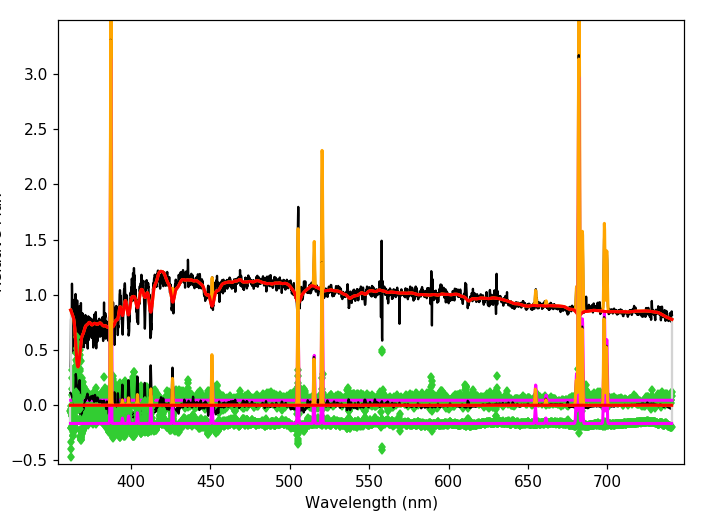

Nonzero Templates: 7 / 150
Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[SII]6716' '[SII]6731' '[OIII]5007_d'
 '[OI]6300_d' '[NII]6583_d']
---------------------------------------------------------


<IPython.core.display.Javascript object>


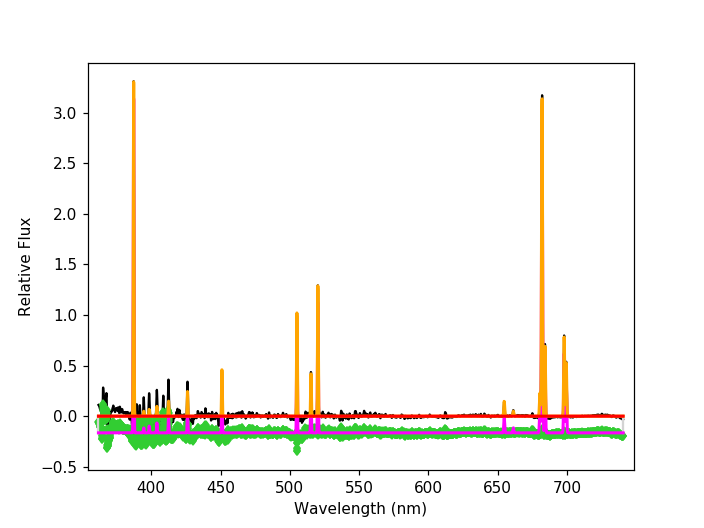

---------end--------


In [12]:
# 2019-04-16:原始的发射线减去连续谱然后进行拟合:
#
import glob
from os import path
from time import perf_counter as clock

import matplotlib.pyplot as plt

import numpy as np
from astropy.io import fits

import ppxf as ppxf_package
import ppxf.miles_util as lib
import ppxf.ppxf_util as util
import ppxf.ppxfgas as gas
from ppxf.ppxf import ppxf
import ppxf.ppxfmpl8 as mpl8
import ppxf.ppxfstellar as stellar


def ppxf_example_population_gas_sdss(flux, galaxy, wave, median_flux, plateifu,
                                     redshift, tie_balmer, limit_doublets):

    ppxf_dir = path.dirname(path.realpath(ppxf_package.__file__))
    # read file
    dirfile = '/Users/astro/Documents/notebooks/zs/result/zoom/' + \
        str(plateifu)+'_all.txt'
    z = redshift
    # ----------
    # information:
    flux = flux
    median_flux = median_flux
    galaxy = galaxy
    wave = wave
    # ------------
    wave *= np.median(util.vac_to_air(wave) / wave)

    # The noise level is chosen to give Chi^2/DOF=1 without regularization (REGUL=0).
    # A constant noise is not a bad approximation in the fitted wavelength
    # range and reduces the noise in the fit.
    #
    noise = np.full_like(galaxy,
                         0.01635)  # Assume constant noise per pixel here

    # The velocity step was already chosen by the SDSS pipeline
    # and we convert it below to km/s
    #
    c = 299792.458  # speed of light in km/s
    velscale = c * np.log(wave[1] / wave[0])  # eq.(8) of Cappellari (2017)
    # SDSS has an approximate instrumental resolution FWHM of 2.76A.
    FWHM_gal = 2.76

    # ------------------- Setup templates -----------------------

    pathname = ppxf_dir + '/miles_models/Mun1.30*.fits'

    # The templates are normalized to mean=1 within the FWHM of the V-band.
    # In this way the weights and mean values are light-weighted quantities
    miles = lib.miles(pathname, velscale, FWHM_gal)

    # The stellar templates are reshaped below into a 2-dim array with each
    # spectrum as a column, however we save the original array dimensions,
    # which are needed to specify the regularization dimensions
    #
    reg_dim = miles.templates.shape[1:]
    stars_templates = miles.templates.reshape(miles.templates.shape[0], -1)

    # See the pPXF documentation for the keyword REGUL,
    regul_err = 0.013  # Desired regularization error

    # Construct a set of Gaussian emission line templates.
    # Estimate the wavelength fitted range in the rest frame.
    #
    lam_range_gal = np.array([np.min(wave), np.max(wave)]) / (1 + z)
    gas_templates, gas_names, line_wave = util.emission_lines(
        miles.log_lam_temp,
        lam_range_gal,
        FWHM_gal,
        tie_balmer=tie_balmer,
        limit_doublets=limit_doublets)

    # Combines the stellar and gaseous templates into a single array.
    # During the PPXF fit they will be assigned a different kinematic
    # COMPONENT value
    #
    templates = np.column_stack([stars_templates, gas_templates])
    # -----------------------------------------------------------

    # The galaxy and the template spectra do not have the same starting wavelength.
    # For this reason an extra velocity shift DV has to be applied to the template
    # to fit the galaxy spectrum. We remove this artificial shift by using the
    # keyword VSYST in the call to PPXF below, so that all velocities are
    # measured with respect to DV. This assume the redshift is negligible.
    # In the case of a high-redshift galaxy one should de-redshift its
    # wavelength to the rest frame before using the line below as described
    # in PPXF_EXAMPLE_KINEMATICS_SAURON and Sec.2.4 of Cappellari (2017)
    #
    c = 299792.458
    dv = c * (miles.log_lam_temp[0] - np.log(wave[0])
              )  # eq.(8) of Cappellari (2017)
    vel = c * np.log(1 + z)  # eq.(8) of Cappellari (2017)
    start = [vel, 180.]  # (km/s), starting guess for [V, sigma]

    n_temps = stars_templates.shape[1]
    n_forbidden = np.sum(["[" in a
                          for a in gas_names])  # forbidden lines contain "[*]"
    n_balmer = len(gas_names) - n_forbidden

    # Assign component=0 to the stellar templates, component=1 to the Balmer
    # gas emission lines templates and component=2 to the forbidden lines.
    component = [0] * n_temps + [1] * n_balmer + [2] * n_forbidden
    gas_component = np.array(
        component) > 0  # gas_component=True for gas templates

    # Fit (V, sig, h3, h4) moments=4 for the stars
    # and (V, sig) moments=2 for the two gas kinematic components
    moments = [4, 2, 2]

    # Adopt the same starting value for the stars and the two gas components
    start = [start, start, start]

    # If the Balmer lines are tied one should allow for gas reddeining.
    # The gas_reddening can be different from the stellar one, if both are fitted.
    gas_reddening = 0 if tie_balmer else None

    # Here the actual fit starts.
    #
    # IMPORTANT: Ideally one would like not to use any polynomial in the fit
    # as the continuum shape contains important information on the population.
    # Unfortunately this is often not feasible, due to small calibration
    # uncertainties in the spectral shape. To avoid affecting the line strength of
    # the spectral features, we exclude additive polynomials (DEGREE=-1) and only use
    # multiplicative ones (MDEGREE=10). This is only recommended for population, not
    # for kinematic extraction, where additive polynomials are always recommended.
    #
    t = clock()
    pp = mpl8.ppxf(dirfile,
                   templates,
                   galaxy,
                   median_flux,
                   noise,
                   velscale,
                   start,
                   plot=True,
                   moments=moments,
                   degree=-1,
                   mdegree=10,
                   vsyst=dv,
                   lam=wave,
                   clean=False,
                   regul=1. / regul_err,
                   reg_dim=reg_dim,
                   component=component,
                   gas_component=gas_component,
                   gas_names=gas_names,
                   gas_reddening=gas_reddening)

    # When the two Delta Chi^2 below are the same, the solution
    # is the smoothest consistent with the observed spectrum.
    #
    #     print('Desired Delta Chi^2: %.4g' % np.sqrt(2 * galaxy.size))
    #     print('Current Delta Chi^2: %.4g' % ((pp.chi2 - 1) * galaxy.size))
    #     print('Elapsed time in PPXF: %.2f s' % (clock() - t))

    weights = pp.weights[
        ~gas_component]  # Exclude weights of the gas templates
    weights = weights.reshape(reg_dim) / weights.sum()  # Normalized

    miles.mean_age_metal(weights)
    miles.mass_to_light(weights, band="r")

    # Plot fit results for stars and gas.
    plt.figure()
    plt.clf()
    pp.plot()
    #     print(pp.gas_names, pp.gas_flux, pp.bestfit)

    # Plot stellar population mass fraction distribution
    #     plt.subplot(212)
    #     miles.plot(weights)
    plt.tight_layout()
    #     plt.ylim(0)
    #     plt.pause(1)
    return pp.bestfit, pp.lam, np.mean(flux)


def ppxf_example_kinematics_sdss(flux, galaxy, lam_gal, plateifu, mask,
                                 redshift):

    ppxf_dir = path.dirname(path.realpath(ppxf_package.__file__))

    # Read SDSS DR12 galaxy spectrum taken from here http://dr12.sdss3.org/
    # The spectrum is *already* log rebinned by the SDSS DR12
    # pipeline and log_rebin should not be used in this case.

    dirfile = '/Users/astro/Documents/notebooks/zs/result/zoom/' + \
        str(plateifu)+'_stellar.txt'

    z = redshift
    flux = flux
    galaxy = galaxy
    lam_gal = lam_gal
    mask = mask
    noise = np.full_like(galaxy, 0.0166)
    c = 299792.458
    frac = lam_gal[1] / lam_gal[0]
    dlamgal = (frac - 1) * lam_gal
    #     print('dla', dlamgal)
    a = np.full((1, 4563), 2.76)
    fwhm_gal = a[0][mask]

    velscale = np.log(frac) * c

    # If the galaxy is at significant redshift, one should bring the galaxy
    # spectrum roughly to the rest-frame wavelength, before calling pPXF
    # (See Sec.2.4 of Cappellari 2017). In practice there is no
    # need to modify the spectrum in any way, given that a red shift
    # corresponds to a linear shift of the log-rebinned spectrum.
    # One just needs to compute the wavelength range in the rest-frame
    # and adjust the instrumental resolution of the galaxy observations.
    # This is done with the following three commented lines:
    #
    # lam_gal = lam_gal/(1+z)  # Compute approximate restframe wavelength
    # fwhm_gal = fwhm_gal/(1+z)   # Adjust resolution in Angstrom

    # Read the list of filenames from the Single Stellar Population library
    # by Vazdekis (2010, MNRAS, 404, 1639) http://miles.iac.es/. A subset
    # of the library is included for this example with permission
    vazdekis = glob.glob(ppxf_dir + '/miles_models/Mun1.30Z*.fits')
    # Vazdekis+10 spectra have a constant resolution FWHM of 2.51A.
    fwhm_tem = 2.51

    # Extract the wavelength range and logarithmically rebin one spectrum
    # to the same velocity scale of the SDSS galaxy spectrum, to determine
    # the size needed for the array which will contain the template spectra.
    #
    hdu = fits.open(vazdekis[0])
    ssp = hdu[0].data
    h2 = hdu[0].header
    lam_temp = h2['CRVAL1'] + h2['CDELT1'] * np.arange(h2['NAXIS1'])
    lamRange_temp = [np.min(lam_temp), np.max(lam_temp)]
    sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale)[0]
    templates = np.empty((sspNew.size, len(vazdekis)))

    # Interpolates the galaxy spectral resolution at the location of every pixel
    # of the templates. Outside the range of the galaxy spectrum the resolution
    # will be extrapolated, but this is irrelevant as those pixels cannot be
    # used in the fit anyway.
    fwhm_gal = np.interp(lam_temp, lam_gal, fwhm_gal)

    # Convolve the whole Vazdekis library of spectral templates
    # with the quadratic difference between the SDSS and the
    # Vazdekis instrumental resolution. Logarithmically rebin
    # and store each template as a column in the array TEMPLATES.

    # Quadratic sigma difference in pixels Vazdekis --> SDSS
    # The formula below is rigorously valid if the shapes of the
    # instrumental spectral profiles are well approximated by Gaussians.
    #
    # In the line below, the fwhm_dif is set to zero when fwhm_gal < fwhm_tem.
    # In principle it should never happen and a higher resolution template should be used.
    #
    fwhm_dif = np.sqrt((fwhm_gal**2 - fwhm_tem**2).clip(0))
    sigma = fwhm_dif / 2.355 / h2['CDELT1']  # Sigma difference in pixels

    for j, fname in enumerate(vazdekis):
        hdu = fits.open(fname)
        ssp = hdu[0].data
        ssp = util.gaussian_filter1d(
            ssp, sigma)  # perform convolution with variable sigma
        sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale)[0]
        templates[:, j] = sspNew / np.median(sspNew)  # Normalizes templates

    # The galaxy and the template spectra do not have the same starting wavelength.
    # For this reason an extra velocity shift DV has to be applied to the template
    # to fit the galaxy spectrum. We remove this artificial shift by using the
    # keyword VSYST in the call to PPXF below, so that all velocities are
    # measured with respect to DV. This assume the redshift is negligible.
    # In the case of a high-redshift galaxy one should de-redshift its
    # wavelength to the rest frame before using the line below (see above).
    #
    c = 299792.458
    dv = np.log(lam_temp[0] / lam_gal[0]) * c  # km/s
    goodpixels = util.determine_goodpixels(np.log(lam_gal), lamRange_temp, z)

    # Here the actual fit starts. The best fit is plotted on the screen.
    # Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
    #
    vel = c * np.log(1 + z)  # eq.(8) of Cappellari (2017)
    start = [vel, 200.]  # (km/s), starting guess for [V, sigma]
    t = clock()

    pp = stellar.ppxf(dirfile,
                      templates,
                      galaxy,
                      noise,
                      velscale,
                      start,
                      goodpixels=goodpixels,
                      plot=False,
                      moments=4,
                      degree=12,
                      vsyst=dv,
                      clean=False,
                      lam=lam_gal)

    #     print("Formal errors:")
    #     print("     dV    dsigma   dh3      dh4")
    #     print("".join("%8.2g" % f for f in pp.error * np.sqrt(pp.chi2)))

    #     print('Elapsed time in PPXF: %.2f s' % (clock() - t))
    return pp.bestfit, pp.lam, np.mean(flux)

    # If the galaxy is at significant redshift z and the wavelength has been
    # de-redshifted with the three lines "z = 1.23..." near the beginning of
    # this procedure, the best-fitting redshift is now given by the following
    # commented line (equation 2 of Cappellari et al. 2009, ApJ, 704, L34):
    #
    #print, 'Best-fitting redshift z:', (z + 1)*(1 + sol[0]/c) - 1


def emission(w1, f1, redshift, plateifu, tie_balmer, limit_doublets):
    ppxf_dir = path.dirname(path.realpath(ppxf_package.__file__))

    dirfile = '/Users/astro/Documents/notebooks/zs/result/zoom/' + \
        str(plateifu)+'_emission_line.txt'

    z = redshift
    flux = f1
    galaxy = flux
    wave = w1

    wave *= np.median(util.vac_to_air(wave) / wave)

    # The noise level is chosen to give Chi^2/DOF=1 without regularization (REGUL=0).
    # A constant noise is not a bad approximation in the fitted wavelength
    # range and reduces the noise in the fit.
    #
    noise = np.full_like(galaxy,
                         0.01635)  # Assume constant noise per pixel here

    # The velocity step was already chosen by the SDSS pipeline
    # and we convert it below to km/s
    #
    c = 299792.458  # speed of light in km/s
    velscale = c * np.log(wave[1] / wave[0])  # eq.(8) of Cappellari (2017)
    # SDSS has an approximate instrumental resolution FWHM of 2.76A.
    FWHM_gal = 2.76

    # ------------------- Setup templates -----------------------

    pathname = ppxf_dir + '/miles_models/Mun1.30*.fits'

    # The templates are normalized to mean=1 within the FWHM of the V-band.
    # In this way the weights and mean values are light-weighted quantities
    miles = lib.miles(pathname, velscale, FWHM_gal)

    # The stellar templates are reshaped below into a 2-dim array with each
    # spectrum as a column, however we save the original array dimensions,
    # which are needed to specify the regularization dimensions
    #
    reg_dim = miles.templates.shape[1:]
    #     stars_templates = miles.templates.reshape(miles.templates.shape[0], -1)

    # See the pPXF documentation for the keyword REGUL,
    regul_err = 0.013  # Desired regularization error

    # Construct a set of Gaussian emission line templates.
    # Estimate the wavelength fitted range in the rest frame.
    #
    lam_range_gal = np.array([np.min(wave), np.max(wave)]) / (1 + z)
    gas_templates, gas_names, line_wave = util.emission_lines(
        miles.log_lam_temp,
        lam_range_gal,
        FWHM_gal,
        tie_balmer=tie_balmer,
        limit_doublets=limit_doublets)

    # Combines the stellar and gaseous templates into a single array.
    # During the PPXF fit they will be assigned a different kinematic
    # COMPONENT value
    #
    templates = gas_templates
    # -----------------------------------------------------------

    # The galaxy and the template spectra do not have the same starting wavelength.
    # For this reason an extra velocity shift DV has to be applied to the template
    # to fit the galaxy spectrum. We remove this artificial shift by using the
    # keyword VSYST in the call to PPXF below, so that all velocities are
    # measured with respect to DV. This assume the redshift is negligible.
    # In the case of a high-redshift galaxy one should de-redshift its
    # wavelength to the rest frame before using the line below as described
    # in PPXF_EXAMPLE_KINEMATICS_SAURON and Sec.2.4 of Cappellari (2017)
    #
    c = 299792.458
    dv = c * (miles.log_lam_temp[0] - np.log(wave[0])
              )  # eq.(8) of Cappellari (2017)
    vel = c * np.log(1 + z)  # eq.(8) of Cappellari (2017)
    start = [vel, 180.]  # (km/s), starting guess for [V, sigma]

    #     n_temps = stars_templates.shape[1]
    n_forbidden = np.sum(["[" in a
                          for a in gas_names])  # forbidden lines contain "[*]"
    n_balmer = len(gas_names) - n_forbidden

    # Assign component=0 to the stellar templates, component=1 to the Balmer
    # gas emission lines templates and component=2 to the forbidden lines.
    component = [0] * n_balmer + [1] * n_forbidden
    gas_component = np.array(
        component) >= 0  # gas_component=True for gas templates

    # Fit (V, sig, h3, h4) moments=4 for the stars
    # and (V, sig) moments=2 for the two gas kinematic components
    moments = [2, 2]

    # Adopt the same starting value for the stars and the two gas components
    start = [start, start]

    # If the Balmer lines are tied one should allow for gas reddeining.
    # The gas_reddening can be different from the stellar one, if both are fitted.
    gas_reddening = 0 if tie_balmer else None

    # Here the actual fit starts.
    #
    # IMPORTANT: Ideally one would like not to use any polynomial in the fit
    # as the continuum shape contains important information on the population.
    # Unfortunately this is often not feasible, due to small calibration
    # uncertainties in the spectral shape. To avoid affecting the line strength of
    # the spectral features, we exclude additive polynomials (DEGREE=-1) and only use
    # multiplicative ones (MDEGREE=10). This is only recommended for population, not
    # for kinematic extraction, where additive polynomials are always recommended.
    #
    t = clock()
    pp = gas.ppxf(dirfile,
                  templates,
                  galaxy,
                  noise,
                  velscale,
                  start,
                  plot=True,
                  moments=moments,
                  degree=-1,
                  mdegree=10,
                  vsyst=dv,
                  lam=wave,
                  clean=False,
                  component=component,
                  gas_component=gas_component,
                  gas_names=gas_names,
                  gas_reddening=gas_reddening)

    # When the two Delta Chi^2 below are the same, the solution
    # is the smoothest consistent with the observed spectrum.
    #
    #     print('Desired Delta Chi^2: %.4g' % np.sqrt(2 * galaxy.size))
    #     print('Current Delta Chi^2: %.4g' % ((pp.chi2 - 1) * galaxy.size))
    #     print('Elapsed time in PPXF: %.2f s' % (clock() - t))

    #     weights = pp.weights[~gas_component]  # Exclude weights of the gas templates
    #     weights = weights.reshape(reg_dim)/weights.sum()  # Normalized

    #     miles.mean_age_metal(weights)
    #     miles.mass_to_light(weights, band="r")

    plt.figure()
    # Plot fit results for stars and gas.
    plt.clf()
    pp.plot()
    #     print(pp.gas_names, pp.gas_flux, pp.bestfit)

    # Plot stellar population mass fraction distribution

    return pp.bestfit, pp.lam


if __name__ == '__main__':
    dir1 = '/Users/astro/Documents/notebooks/zs/result/stackfits/'
    z = fits.open('/Users/astro/Documents/notebooks/zs/ppxf_yxl/z_mpl8.fits')
    data = z[1].data
    pifu = data.field('PLATEIFU')
    z_info = data.field('Z')
    all_file = glob.glob(dir1 + '*.fits')
    for j in range(0, 1):
        i = all_file[j]
        #         dirfile='/home/zhaisai/zhaisai/result/mpl8/2019_04_17_new/'+i[48:-5]+'_all.txt'
        dirfile = '/Users/astro/Documents/notebooks/zs/result/zoom/' + \
            '10001-12701'+'_stellar.txt'
        if path.exists(dirfile):
            continue
        else:
            print('-------start--------------')
            print('********' + i + '************')
            #             plateifu=i[48:-5]
            plateifu = '10001-12701'
            print(plateifu)
            index = np.where(pifu == plateifu)[0]
            z1 = z_info[index]
            file = fits.open(i)
            t = file[1].data
            mask1 = (t['col0'] > 3540) & (t['col0'] < 7409)
            m = 0
            for q in t.columns:
                m += 1
            if m >= 4:
                flux = t['col3'][mask1]
                galaxy = flux / np.median(flux)
                wave = t['col0'][mask1]
                plt.figure()
                plt.plot(wave, flux, label='real flux')

                plt.legend()
                plt.figure()
                plt.plot(wave, galaxy, label='galaxy')
                plt.legend()
                f1, w1, mean_f1 = ppxf_example_population_gas_sdss(
                    flux,
                    galaxy,
                    wave,
                    np.median(flux),
                    plateifu,
                    z1,
                    tie_balmer=True,
                    limit_doublets=False)
                f2, w2, mean_f2 = ppxf_example_kinematics_sdss(
                    flux, galaxy, wave, plateifu, mask1, z1)
                emission(w1,
                         f1 - f2,
                         z1,
                         plateifu,
                         tie_balmer=True,
                         limit_doublets=False)
                print('---------end--------')

            else:
                print('----no-----')
                
                
                
           # orange: galaxy
        # magenta: emission line;

In [11]:
pwd

'/Users/astro/Documents/notebooks/zs/ppxf_v2'

# z_do2

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
from astropy.io import fits
from astropy.table import Table
from scipy.misc import derivative

np.seterr(divide='ignore', invalid='ignore')


def do2(xi, xi_e):
    metal = []
    sigma = []
    for i in range(0, len(xi), 1):
        x = xi[i]
        x_e = xi_e[i]
        metal.append(9.12 + 0.73 * x)
        sigma.append(0.73 * x_e)
    return np.array(metal), np.array(sigma)


def rred(wl, f, f_e, e_bv):
    k_ha = 1.17 * (-1.857 + 1.040 / 0.6564) + 1.78
    k_hb = 1.17 * (-2.156 + 1.509 / 0.4862 - 0.198 / (0.4862**2) + 0.011 /
                    (0.4862**3)) + 1.78
    a = f
    wl = wl / 10000.0
    if 0.63 <= wl <= 2.2:
        k = 1.17 * (-1.857 + 1.040 / wl) + 1.78
    elif 0.12 <= wl <= 0.63:
        k = 1.17 * (-2.156 + 1.509 / wl - 0.198 / (wl**2) + 0.011 /
                     (wl**3)) + 1.78
    f = sy.symbols('f')
    y = f * 10**(0.4 * k * e_bv)
    y_df = sy.diff(y, f)
    df = float(y_df.subs({f: a}))
    sigma = sy.sqrt(df**2 * float(f_e)**2)
    return float(y.subs({f: a})), sigma

dir1 = '/Users/astro/Documents/notebooks/zs/pair-m-z/res/'  # result
dir2 = '/Users/astro/Documents/notebooks/zs/data/'  # data
f_emi_miss=open('/Users/astro/Documents/notebooks/zs/pair-m-z/res/'+'z_do2_miss_emis_10_25.info','a+')
f_info = open('/Users/astro/Documents/notebooks/zs/pair-m-z/res/' + 'z_do2_10_25.txt', 'a+')
f_nomass=open('/Users/astro/Documents/notebooks/zs/pair-m-z/res/z_do2__10_25_no_mass.info','a+')
dir3='/Users/astro/Documents/notebooks/zs/2019-09-17/' # stellar mass file
print('PLATEIFU',
      'ebv',
      'mag_r',
      'mag_i',
      'mass_median',
      'mass_p16',
      'mass_p84',
      'mass_p2p5',
      'mass_p97p5',
      'mass_mode',
      'mass_avg',
      'balmer',
      'balmer_err',
      'NII',
      'NII_e',
      'Hbeta',
      'Hbeta_e',
      'Halpha',
      'Halpha_e',
      'NII_r',
      'NII_e_r',
      'Hbeta_r',
      'Hbeta_e_r',
      'Halpha_r',
      'Halpha_e_r',
      'z_do2',
      'z_do2_e',
      file=f_info)


emissionfile = glob.glob(dir1 + '*show*')

# 获取星等信息
f_mag = fits.open(dir2 + 'drpall-v2_5_3.fits')
data = f_mag[1].data
mag = data.field('nsa_sersic_absmag')
mag_plateifu = data.field('plateifu')

# 获取stellar mass信息：
f_mass=fits.open(dir3+'dr7_mpl8')
data1=f_mass[1].data
mass_median=data1['MEDIAN']
mass_p16=data1['P16']
mass_p84=data1['P84']
mass_p2p5=data1['P2P5']
mass_p97p5=data1['P97P5']
mass_mode=data1['MODE']
mass_avg=data1['AVG']
mass_plateifu=data1['plateifu']


print('_____________start')
j = 0
for i in range(0, len(emissionfile)):
    filename = emissionfile[i]
    j += 1
    len1=len(dir1) # dir1 的长度
    len2=len('_show.jpg') # 后缀的长度

    if os.path.exists(filename[:-len2]+'.txt'):        
        col0 = filename[len1:]
        plateifu = col0[:-len2]
        index = np.where(mag_plateifu == plateifu)[0]
        # mag 数据获取
        mag1 = mag[index]
        # stellar mass 数据获取
        index1= np.where(mass_plateifu==plateifu)[0]
        if len(index1)>0:
            mass_median1=mass_median[index1[0]]
            mass_p16_1=mass_p16[index1[0]]
            mass_p84_1=mass_p84[index1[0]]
            mass_p2p5_1=mass_p2p5[index1[0]]
            mass_p97p5_1=mass_p97p5[index1[0]]
            mass_mode1=mass_mode[index1[0]]
            mass_avg1=mass_avg[index1[0]]
        else:
            print('plateifu without mass info: ',plateifu, file=f_nomass)   
            mass_p16_1=mass_p84_1=mass_p2p5_1=mass_p97p5_1=mass_mode1=mass_avg1=-99
        # 读取flux数据信息:
        print(filename)
        f = open(filename[:-len2]+'.txt', 'r')
        line = f.readlines()
        print(line[13])
        e_bv = float(line[13][21:])
        info = []
        for i in range(20, len(line)):
            info.append(line[i])
        flux1 = [i.strip().split()[3] for i in info]
        flux1 = map(float, flux1)
        flux1 = list(flux1)
        name1 = [i.strip().split()[2] for i in info]
        err = [i.strip().split()[4] for i in info]
        # 计算结果
        if 'Balmer' in name1 and'[NII]6583_d' in name1:
            if flux1[name1.index('Balmer')] > 0 and flux1[name1.index('[NII]6583_d')]>0:
                nii = flux1[name1.index('[NII]6583_d')]
                nii_err = err[name1.index('[NII]6583_d')]
                balmer = flux1[name1.index('Balmer')]
                balmer_err = err[name1.index('Balmer')]

                #                 print('balmer',type(balmer),type(ratio),type(balmer_err))
                ratio = 0.0530 + 0.0731 + 0.105 + 0.159 + 0.259 + 0.468 + 1 + 2.86
                halpha = balmer * 2.86 / ratio
                halpha_err = float(balmer_err) * 2.86 / ratio
                hbeta = balmer / ratio
                hbeta_err = float(balmer_err) / ratio

                # 消光改正

                nii_r, nii_err_r = rred(6583, nii, nii_err, e_bv)
                halpha_r, halpha_err_r = rred(6563, halpha, halpha_err, e_bv)
                hbeta_r, hbeta_err_r = rred(4861, hbeta, hbeta_err, e_bv)

                # function
                a, f, a1, f1 = sy.symbols('a f a1 f1')
                f_n2 = sy.log(a / f, 10)
                # diff
                df_n2_a = sy.diff(f_n2, a)
                df_n2_f = sy.diff(f_n2, f)
                # error
                sigma_n2 = sy.sqrt((df_n2_a * a1)**2 + (df_n2_f * f1)**2)

                n2_err = float(
                    sigma_n2.subs({
                        a: nii_r,
                        a1: nii_err_r,
                        f: halpha_r,
                        f1: halpha_err_r
                    }))

                # 数据
                print(nii_r,halpha_r)
                n2 = float(f_n2.subs({a: nii_r, f: halpha_r}))

                # 计算金属丰度
                z_do2, z_do2_e = do2([n2], [n2_err])

                print(plateifu,
                      e_bv,
                      mag1[0, 4],
                      mag1[0, 5],
                      mass_median1,
                      mass_p16_1,
                      mass_p84_1,
                      mass_p2p5_1,
                      mass_p97p5_1,
                      mass_mode1,
                      mass_avg1,
                      balmer,
                      balmer_err,
                      nii,
                      nii_err,
                      hbeta,
                      hbeta_err,
                      halpha,
                      halpha_err,
                      nii_r,
                      nii_err_r,
                      hbeta_r,
                      hbeta_err_r,
                      halpha_r,
                      halpha_err_r,
                      z_do2[0],
                      z_do2_e[0],
                      file=f_info)

            else:
                print('file missing emission line info',filename,file=f_emi_miss)        
        

f_info.close()
f_emi_miss.close()
f_nomass.close()
print('___________finished')

_____________start
___________finished


In [64]:
len('/Users/astro/Documents/notebooks/zs/result/2019_04_23_new/2019_04_17_new/')

73

In [9]:
emissionfile

[]

# z_kdo2

In [14]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
from astropy.io import fits
from astropy.table import Table
from scipy.misc import derivative

np.seterr(divide='ignore', invalid='ignore')


def kd02(logn2o, log23, logo32, logn2o_err, log23_err, logo32_err):
    metal = []
    sigma = []
    for i in range(0, len(logn2o)):
        log_n2o = logn2o[i]
        log_23 = log23[i]
        log_o32 = logo32[i]
        n2o_e = logn2o_err[i]
        o32_e = logo32_err[i]
        r23_e = log23_err[i]

        if log_n2o > -1.2:
            z = sy.symbols('z', real=True)
            func = 1106.8660 - 532.15451 * z + 96.373260 * z**2 - \
                7.8106123 * z**3 + 0.23928247 * z**4 - log_n2o
            func1 = 1106.8660 - 532.15451 * z + 96.373260 * \
                z**2 - 7.8106123 * z**3 + 0.23928247 * z**4
            tmp = sy.solve(func, z)
            tmp_metal = [n for n in tmp if n > 8.4]
            if len(tmp_metal) >= 1:
                metal.append(np.min(tmp_metal))
                func1_dz = sy.diff(func1, z)
                dz = float(func1_dz.subs({z: np.min(tmp_metal)}))
                sigma_kd02 = n2o_e / dz
                sigma.append(sigma_kd02)

            elif len(tmp_metal) == 0:
                metal.append(np.max(tmp))
                func1_dz = sy.diff(func1, z)
                dz = float(func1_dz.subs({z: np.max(tmp)}))
                sigma_kd02 = n2o_e / dz
                sigma.append(sigma_kd02)
            else:
                print('wrong')
        else:
            # m91的金属丰度以及误差计算
            m91_a, m91_b = sy.symbols('m91_a m91_b')
            z_m91 = 12 - 4.944 + 0.767 * m91_a + 0.602 * m91_a**2 - m91_b * (
                0.29 + 0.332 * m91_a - 0.331 * m91_a**2)
            m91_da = sy.diff(z_m91, m91_a)
            m91_db = sy.diff(z_m91, m91_b)

            da = float(m91_da.subs({m91_a: log_23, m91_b: log_o32}))
            db = float(m91_db.subs({m91_a: log_23, m91_b: log_o32}))

            sigma_m91 = np.sqrt(da**2 * r23_e**2 + db**2 * o32_e**2)
            m91_z = float(z_m91.subs({m91_a: log_23, m91_b: log_o32}))

            # kk04金属丰度和误差计算
            kk04_a, kk04_b = sy.symbols('kk04_a kk04_b')

            q = ((32.81 - 1.153 * kk04_a**2 + 8.2 *
                  (-3.396 - 0.025 * kk04_a + 0.1444 * kk04_a**2)) /
                 (4.603 - 0.3119 * kk04_a - 0.163 * kk04_a**2 + 8.2 *
                  (-0.48 + 0.0271 * kk04_a + 0.02037 * kk04_a**2)))

            z_kk04 = 9.4 + 4.65 * kk04_b - 3.17 * kk04_b**2 - sy.log(q,10) * (
                0.272 + 0.547 * kk04_b - 0.513 * kk04_b**2)

            kk04_da = sy.diff(z_kk04, kk04_a)
            kk04_db = sy.diff(z_kk04, kk04_b)

            da1 = float(kk04_da.subs({kk04_a: log_o32, kk04_b: log_23}))
            db1 = float(kk04_db.subs({kk04_a: log_o32, kk04_b: log_23}))

            sigma_kk04 = np.sqrt(da1**2 * o32_e**2 + db1**2 * r23_e**2)
            kk04_z = float(z_kk04.subs({kk04_a: log_o32, kk04_b: log_23}))
            # kd02金属丰度
            sigma_kd02 = np.sqrt(sigma_m91**2 / 4 + sigma_kk04**2 / 4)
            sigma.append(sigma_kd02)

            metal.append((m91_z + kk04_z) / 2)
    return np.array(metal), np.array(sigma)


def rred(wl, f, f_e, e_bv):
    k_ha = 1.17 * (-1.857 + 1.040 / 0.6564) + 1.78
    k_hb = 1.17 * (-2.156 + 1.509 / 0.4862 - 0.198 / (0.4862**2) + 0.011 /
                    (0.4862**3)) + 1.78
    a = f
    wl = wl / 10000.0
    if 0.63 <= wl <= 2.2:
        k = 1.17 * (-1.857 + 1.040 / wl) + 1.78
    elif 0.12 <= wl <= 0.63:
        k = 1.17 * (-2.156 + 1.509 / wl - 0.198 / (wl**2) + 0.011 /
                     (wl**3)) + 1.78
    f = sy.symbols('f')
    y = f * 10**(0.4 * k * e_bv)
    y_df = sy.diff(y, f)
    df = float(y_df.subs({f: a}))
    sigma = sy.sqrt(df**2 * float(f_e)**2)
    return float(y.subs({f: a})), sigma

dir1 = '/Users/astro/Documents/notebooks/zs/pair-m-z/res/'  # result
dir2 = '/Users/astro/Documents/notebooks/zs/data/'  # data
f_emi_miss=open('/Users/astro/Documents/notebooks/zs/pair-m-z/res/'+'z_kd02_miss_emis_10_25.info','a+')
f_info = open('/Users/astro/Documents/notebooks/zs/pair-m-z/res/' + 'z_kd02_10_25.txt', 'a+')
f_nomass=open('/Users/astro/Documents/notebooks/zs/pair-m-z/res/z_kd02_10_25_no_mass.info','a+')
dir3='/Users/astro/Documents/notebooks/zs/2019-09-17/' # stellar mass file
print('PLATEIFU',
      'ebv',
      'mag_r',
      'mag_i',
      'mass_median',
      'mass_p16',
      'mass_p84',
      'mass_p2p5',
      'mass_p97p5',
      'mass_mode',
      'mass_avg',
      'balmer',
      'balmer_err',
      'NII',
      'NII_e',
      'OIII',
      'OIII_e',
      'OII_3726',
      'OII_3726_e',
      'OII_3729',
      'OII_3729_e',      
      'Hbeta',
      'Hbeta_e',
      'Halpha',
      'Halpha_e',
      'NII_r',
      'NII_e_r',
      'OIII_r',
      'OIII_e_r',
      'OII_3726_r',
      'OII_3726_e_r',
      'OII_3729_r',
      'OII_3729_e_r',
      'Hbeta_r',
      'Hbeta_e_r',
      'Halpha_r',
      'Halpha_e_r',
      'z_kd02',
      'z_kd02_e',
      file=f_info)


emissionfile = glob.glob(dir1 + '*show*')

# 获取星等信息
f_mag = fits.open(dir2 + 'drpall-v2_5_3.fits')
data = f_mag[1].data
mag = data.field('nsa_sersic_absmag')
mag_plateifu = data.field('plateifu')

# 获取stellar mass信息：
f_mass = fits.open(dir3+'dr7_mpl8')
data1 = f_mass[1].data
mass_median = data1['MEDIAN']
mass_p16 = data1['P16']
mass_p84 = data1['P84']
mass_p2p5 = data1['P2P5']
mass_p97p5 = data1['P97P5']
mass_mode = data1['MODE']
mass_avg = data1['AVG']
mass_plateifu = data1['plateifu']


print('_____________start')
j = 0
for i in range(0, len(emissionfile)):
    filename = emissionfile[i]

    j += 1
    len1 = len(dir1)
    len2 = len('_show.jpg')
    if os.path.exists(filename[:-len2]+'.txt'):

        col0 = filename[len1:]
        plateifu = col0[:-len2]
        index = np.where(mag_plateifu == plateifu)[0]
        # mag 数据获取
        mag1 = mag[index]
        # stellar mass 数据获取
        index1 = np.where(mass_plateifu == plateifu)[0]
        if len(index1)>0:
            mass_median1 = mass_median[index1[0]]
            mass_p16_1 = mass_p16[index1[0]]
            mass_p84_1 = mass_p84[index1[0]]
            mass_p2p5_1 = mass_p2p5[index1[0]]
            mass_p97p5_1 = mass_p97p5[index1[0]]
            mass_mode1 = mass_mode[index1[0]]
            mass_avg1 = mass_avg[index1[0]]
        else:
            print('plateifu without mass info: ', plateifu, file=f_nomass)
            mass_p16_1=mass_p84_1=mass_p2p5_1=mass_p97p5_1=mass_mode1=mass_avg1=-99

        print(filename[:-len2]+'.txt')
        # 读取flux数据信息:
        f = open(filename[:-len2]+'.txt', 'r')
        line = f.readlines()
        e_bv = float(line[13][21:])
        info = []
        for i in range(20, len(line)):
            info.append(line[i])
        flux1 = [i.strip().split()[3] for i in info]
        flux1 = map(float, flux1)
        flux1 = list(flux1)
        name1 = [i.strip().split()[2] for i in info]
        err = [i.strip().split()[4] for i in info]
        # 计算结果
        if 'Balmer' in name1 and '[NII]6583_d' in name1 and '[OII]3726' in name1 and '[OIII]5007_d' in name1:
            if flux1[name1.index('Balmer')] > 0 and flux1[name1.index(
                    '[OII]3726'
            )] > 0 and flux1[name1.index('[OIII]5007_d')] >0 and flux1[name1.index('[NII]6583_d')]>0:

                nii = flux1[name1.index('[NII]6583_d')]
                nii_err = err[name1.index('[NII]6583_d')]
                oiii = flux1[name1.index('[OIII]5007_d')]
                oiii_err = err[name1.index('[OIII]5007_d')]
                oii_3726 = flux1[name1.index('[OII]3726')]
                oii_3726_err = err[name1.index('[OII]3726')]
                oii_3729 = flux1[name1.index('[OII]3729')]
                oii_3729_err = err[name1.index('[OII]3729')]
                balmer = flux1[name1.index('Balmer')]
                balmer_err = err[name1.index('Balmer')]

                ratio = 0.0530 + 0.0731 + 0.105 + 0.159 + 0.259 + 0.468 + 1 + 2.86
                halpha = balmer * 2.86 / ratio
                halpha_err = float(balmer_err) * 2.86 / ratio
                hbeta = balmer / ratio
                hbeta_err = float(balmer_err) / ratio

                # 消光改正

                nii_r, nii_err_r = rred(6583, nii, nii_err, e_bv)
                oiii_r, oiii_err_r = rred(5007, oiii, oiii_err, e_bv)
                oii_3726_r, oii_3726_err_r = rred(
                    3726, oii_3726, oii_3726_err, e_bv)
                oii_3729_r, oii_3729_err_r = rred(
                    3729, oii_3729, oii_3729_err, e_bv)
                hbeta_r, hbeta_err_r = rred(4861, hbeta, hbeta_err, e_bv)
                halpha_r, halpha_err_r = rred(6563, halpha, halpha_err, e_bv)

                # function
                a, b, c, d, e, f, a1, b1, c1, d1, e1, f1 = sy.symbols(
                    'a b c d e f a1 b1 c1 d1 e1 f1')
                f_no = sy.log(a / (b + c), 10)
                f_r23 = sy.log((d * 4 / 3 + c + b) / e, 10)
                f_o32 = sy.log((d / (b + c)), 10)
                # diff
                df_no_a = sy.diff(f_no, a)
                df_no_b = sy.diff(f_no, b)
                df_no_c = sy.diff(f_no, c)
                df_r23_d = sy.diff(f_r23, d)
                df_r23_c = sy.diff(f_r23, c)
                df_r23_b = sy.diff(f_r23, b)
                df_r23_e = sy.diff(f_r23, e)
                df_o32_d = sy.diff(f_o32, d)
                df_o32_b = sy.diff(f_o32, b)
                df_o32_c = sy.diff(f_o32, c)
                # error
                sigma_no = sy.sqrt((df_no_a * a1)**2 + (df_no_b * b1)**2 +
                                   (df_no_c * c1)**2)
                sigma_r23 = sy.sqrt((df_r23_d * d1)**2 + (df_r23_c * c1)**2 +
                                    (df_r23_b * b1)**2 + (df_r23_e * e1)**2)
                sigma_o32 = sy.sqrt((df_o32_d * d1)**2 + (df_o32_b * b1)**2 +
                                    (df_o32_c * c1)**2)

                no_err = float(
                    sigma_no.subs({
                        a: nii_r,
                        b: oii_3726_r,
                        c: oii_3729_r,
                        a1: nii_err_r,
                        b1: oii_3726_err_r,
                        c1: oii_3729_err_r
                    }))
                r23_err = float(
                    sigma_r23.subs({
                        b: oii_3726_r,
                        c: oii_3729_r,
                        b1: oii_3726_err_r,
                        c1: oii_3729_err_r,
                        d: oiii_r,
                        d1: oiii_err_r,
                        e: hbeta_r,
                        e1: hbeta_err_r
                    }))
                o32_err = float(
                    sigma_o32.subs({
                        d: oiii_r,
                        d1: oiii_err_r,
                        b: oii_3726_r,
                        c: oii_3729_r,
                        b1: oii_3726_err_r,
                        c1: oii_3729_err_r
                    }))

                # 数据
                print('no',f_no.subs({
                        a: nii_r,
                        b: oii_3726_r,
                        c: oii_3729_r
                    }))
                no = float(
                    f_no.subs({
                        a: nii_r,
                        b: oii_3726_r,
                        c: oii_3729_r
                    }))
                r23 = float(
                    f_r23.subs({
                        b: oii_3726_r,
                        c: oii_3729_r,
                        d: oiii_r,
                        e: hbeta_r
                    }))
                o32 = float(
                    f_o32.subs({
                        b: oii_3726_r,
                        c: oii_3729_r,
                        d: oiii_r
                    }))

                # 计算金属丰度
                z_kd02, z_kd02_e = kd02([no], [r23], [o32], [no_err],
                                        [r23_err], [o32_err])

                print(plateifu,
                      e_bv,
                      mag1[0, 4],
                      mag1[0, 5],
                      mass_median1,
                      mass_p16_1,
                      mass_p84_1,
                      mass_p2p5_1,
                      mass_p97p5_1,
                      mass_mode1,
                      mass_avg1,
                      balmer,
                      balmer_err,
                      nii,
                      nii_err,
                      oiii,
                      oiii_err,
                      oii_3726,
                      oii_3726_err,
                      oii_3729,
                      oii_3729_err,
                      hbeta,
                      hbeta_err,
                      halpha,
                      halpha_err,
                      nii_r,
                      nii_err_r,
                      oiii_r,
                      oiii_err_r,
                      oii_3726_r,
                      oii_3726_err_r,
                      oii_3729_r,
                      oii_3729_err_r,
                      hbeta_r,
                      hbeta_err_r,
                      halpha_r,
                      halpha_err_r,
                      z_kd02[0],
                      z_kd02_e[0],
                      file=f_info)

            else:
                print('missing emission line: ',filename,file=f_emi_miss)

        

f_info.close()
f_emi_miss.close()
f_nomass.close()
print('________________finished')

_____________start
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10001-12701.txt
no -1.17209411882957/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10001-12702.txt
no -0.780960590269701/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10001-12703.txt
no -0.21852967616719/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10001-12704.txt
no -0.224711467156107/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10001-12705.txt
no -0.103547786785083/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10001-3702.txt
no 0.477752113409455/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10001-6104.txt
no -0.867986443736187/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10001-9101.txt
no -0.96223004341684/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10001-9102.txt
no -0.110807120945001/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10213-12702.txt
no -1.535

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10220-6103.txt
no 0.669272290447222/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10220-6104.txt
no 0.308781454679031/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10220-9101.txt
no 0.19646514295194/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10220-9102.txt
no -1.96939214560206/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10221-12702.txt
no -2.82149506186833/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10221-12703.txt
no -1.89198066307517/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10221-12704.txt
no -2.27528168089137/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10221-12705.txt
no -2.09320229094566/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10221-1901.txt
no -0.92889179859171/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10221-1902.txt
no -0.784697375528412/log(10)
/Users

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10503-6102.txt
no 0.228553204578285/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10503-6103.txt
no -0.977998409410783/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10503-6104.txt
no -0.414494352912789/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10503-9102.txt
no -0.686871859422273/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10504-12701.txt
no 0.067114082931026/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10504-12703.txt
no -1.76893788202614/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10504-12704.txt
no -0.398844243024967/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10504-6104.txt
no 0.48919309665698/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10504-9102.txt
no 0.456469608077336/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10506-12701.txt
no -0.867896911172653/log(10)
/U

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10516-12705.txt
no -1.73639765267137/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10516-1901.txt
no 0.167158129784918/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10516-1902.txt
no -0.237208716433866/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10516-3702.txt
no 0.227520672408882/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10516-3704.txt
no -0.0116282937635498/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10516-6102.txt
no -1.57691213303416/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10516-6103.txt
no 0.0178160057906716/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10516-6104.txt
no 0.517918491522776/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10516-9102.txt
no -2.02279826446891/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/10517-12701.txt
no -1.89537428226683/log(10)
/Use

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/7958-6101.txt
no 0.510252551358649/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/7958-6103.txt
no -0.451859612091675/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/7958-9102.txt
no -0.101955200615256/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/7960-12701.txt
no 0.401135896789257/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/7960-12703.txt
no -0.35101588253892/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/7960-12704.txt
no -0.32415750892414/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/7960-12705.txt
no 0.576779041648249/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/7960-3701.txt
no -0.166288314148849/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/7960-3704.txt
no -1.9596618569107/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/7960-6101.txt
no -1.38528864969123/log(10)
/Users/astro/D

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/7991-1902.txt
no 0.288277639863684/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/7991-3704.txt
no 0.0682799612198944/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/7991-6103.txt
no -0.215784587664105/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/7991-6104.txt
no 0.805253129992092/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/7991-9101.txt
no -0.111516266080049/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/7992-12703.txt
no -2.15017800631305/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/7992-1901.txt
no -0.774050096132533/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/7992-3702.txt
no -0.454732601986164/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/7992-3704.txt
no -0.626086742377031/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/7992-6101.txt
no 0.355102104936031/log(10)
/Users/astro/

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8083-12704.txt
no 0.0408771710412788/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8083-12705.txt
no -0.608783758478121/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8083-3702.txt
no -0.372266089507756/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8083-3703.txt
no -0.366526818037717/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8083-6102.txt
no -0.498978612356852/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8083-6103.txt
no -0.49544122324869/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8084-12701.txt
no -1.12836206015727/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8084-12703.txt
no 0.348436377288578/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8084-12704.txt
no -0.305545476813352/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8084-12705.txt
no -0.0897682229266096/log(10)
/Users

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8137-12701.txt
no -0.587232092710654/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8137-12702.txt
no -0.469213198449246/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8137-12703.txt
no 0.105660988072899/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8137-12704.txt
no -1.08394366060115/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8137-12705.txt
no -0.759013640981057/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8137-3701.txt
no -0.0368743536473678/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8137-3702.txt
no 1.10255986561305/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8137-3703.txt
no -0.719717591858867/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8137-3704.txt
no 0.122427375375/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8138-12701.txt
no -0.950146498253299/log(10)
/Users/astr

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8146-3702.txt
no -0.211919813974006/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8146-6103.txt
no -2.15830350333529/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8146-6104.txt
no -0.450207742504581/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8146-9101.txt
no -1.85229140098507/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8147-12701.txt
no -1.2532241522803/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8147-12703.txt
no 0.0144584210318963/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8147-12704.txt
no -2.50604917975093/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8147-1901.txt
no 0.294096921950351/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8147-1902.txt
no -0.523979535708218/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8147-3701.txt
no -0.986155746385065/log(10)
/Users/astro/

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8155-3701.txt
no -1.44655271075441/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8155-3702.txt
no 0.266546186703807/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8155-3703.txt
no -0.304445708295866/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8155-3704.txt
no 0.585680654984488/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8155-6101.txt
no -0.50112505597509/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8155-6102.txt
no -0.099148488721657/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8155-6103.txt
no 0.542435603278554/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8155-6104.txt
no 0.131883364817295/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8155-9102.txt
no -0.699650955517799/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8156-12701.txt
no -0.888968197019921/log(10)
/Users/astro/Do

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8248-9101.txt
no -0.46957134220041/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8249-12701.txt
no -1.56142093473169/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8249-12702.txt
no -1.49918398530676/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8249-12704.txt
no 0.201762549203695/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8249-3702.txt
no -0.449154189640512/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8249-3703.txt
no 0.105771999892507/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8249-6102.txt
no -0.540110246070796/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8249-9101.txt
no -0.0845417034641418/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8250-12702.txt
no -0.523252234200039/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8250-12703.txt
no -2.55598238727766/log(10)
/Users/ast

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8259-12703.txt
no -1.63652716033105/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8259-12704.txt
no -1.28239060384166/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8259-1901.txt
no -1.34879801693212/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8259-1902.txt
no 0.775625158982274/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8259-3702.txt
no -0.25781306701975/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8259-3704.txt
no 0.723556093815938/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8259-6101.txt
no -1.46696151036579/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8259-6104.txt
no -0.0272348043298737/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8259-9101.txt
no -2.53550240978783/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8259-9102.txt
no 0.275656015908761/log(10)
/Users/astro/Doc

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8312-6104.txt
no 0.234416877636183/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8313-12701.txt
no -0.0188459501877945/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8313-12702.txt
no -0.170224072166281/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8313-12703.txt
no 0.307324560735917/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8313-12705.txt
no 0.00514835382305176/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8313-1901.txt
no -2.03075387882607/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8313-1902.txt
no -0.803284854917393/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8313-6101.txt
no 0.773598796654603/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8313-6103.txt
no -0.2914125913832/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8313-6104.txt
no -1.7588760479972/log(10)
/Users/astro

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8324-3702.txt
no -0.557029366833543/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8324-3704.txt
no 0.739617663428861/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8324-6102.txt
no -0.863054904874925/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8324-6103.txt
no 0.420764241755884/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8324-6104.txt
no -0.134940164254343/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8324-9101.txt
no -0.227691236883063/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8324-9102.txt
no -0.979915500481626/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8325-12701.txt
no -0.943794741587688/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8325-12702.txt
no -1.72900305400652/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8325-12705.txt
no -0.70382685549993/log(10)
/Users/astr

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8335-12702.txt
no -1.43466628403839/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8335-12703.txt
no -0.790306891396488/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8335-12704.txt
no -1.26814049400215/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8335-12705.txt
no -0.137184661523239/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8335-3701.txt
no -1.10996211979889/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8335-3702.txt
no 0.0829824738095501/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8335-3704.txt
no -0.356425957470558/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8335-6102.txt
no -1.60014584434003/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8335-6104.txt
no 0.588342695438716/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8335-9102.txt
no -1.99050195531365/log(10)
/Users/astro

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8442-1902.txt
no -1.72902104904405/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8442-3701.txt
no -0.601668389097184/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8442-3704.txt
no 0.149039358051756/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8442-6101.txt
no 0.516358998996258/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8442-6102.txt
no -1.43975506814918/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8442-9101.txt
no -1.52637797213562/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8443-12702.txt
no 0.721567650343279/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8443-12703.txt
no 0.239985103487163/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8443-12705.txt
no 0.500113585700262/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8443-1902.txt
no -0.276453193861262/log(10)
/Users/astro/Do

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8450-9101.txt
no -0.171834055260399/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8451-12701.txt
no -0.0746801382166596/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8451-12703.txt
no -1.37212573083198/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8451-12704.txt
no 0.521738699656311/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8451-12705.txt
no -0.345105494848504/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8451-3701.txt
no 0.290558794049323/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8451-3702.txt
no -0.487938780338381/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8451-3704.txt
no -0.205682975895635/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8451-6103.txt
no -0.151836193706191/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8451-9102.txt
no -1.60243686727355/log(10)
/Users/as

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8461-3704.txt
no 0.462257513717772/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8461-6102.txt
no 0.0654846877863271/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8461-6104.txt
no -0.0499720577002273/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8461-9102.txt
no -0.167790590589613/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8462-12701.txt
no -1.373105177145/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8462-12702.txt
no -1.95213152398176/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8462-12703.txt
no -0.835504203392633/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8462-12704.txt
no -2.15538575760239/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8462-1902.txt
no 0.547825062760201/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8462-3701.txt
no 0.253678837373376/log(10)
/Users/astro/

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8486-12702.txt
no -1.51271170240893/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8486-12703.txt
no -1.67358027004923/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8486-12704.txt
no -1.31755796124323/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8486-12705.txt
no 0.275417759077262/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8486-1901.txt
no -0.251413813253925/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8486-3704.txt
no -0.632196773457653/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8486-6101.txt
no 0.639324672609242/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8486-6102.txt
no 0.0320691859543336/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8486-9101.txt
no -0.328366383892447/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8486-9102.txt
no -0.28273505005305/log(10)
/Users/astro

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8554-6104.txt
no 0.182982262717141/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8554-9101.txt
no -0.823681034325821/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8555-12703.txt
no 0.0578873059337145/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8555-12705.txt
no 0.498600574175024/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8555-1901.txt
no 0.298493915326299/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8555-1902.txt
no 0.397817823302549/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8555-3701.txt
no -0.427014543764729/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8555-3703.txt
no 0.0381005255021434/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8555-6102.txt
no 0.17667689193837/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8555-9102.txt
no -0.468263010555194/log(10)
/Users/astro/D

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8595-6104.txt
no 0.862427008410977/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8595-9102.txt
no -0.136456573735978/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8597-12701.txt
no 0.069036450783603/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8597-12702.txt
no -0.0259612409729632/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8597-12705.txt
no -0.745328655886228/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8597-1901.txt
no -0.350763668028137/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8597-1902.txt
no -0.746593338820171/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8597-3702.txt
no 0.549367120250606/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8597-3703.txt
no -0.417224030051331/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8597-6102.txt
no 0.561792358454722/log(10)
/Users/ast

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8615-3703.txt
no 0.594062962700488/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8615-9101.txt
no 0.23874261000872/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8615-9102.txt
no 0.403753332638781/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8616-12704.txt
no 0.555092485355037/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8616-1901.txt
no -1.05617221097732/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8616-1902.txt
no -0.373927035998709/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8616-3703.txt
no 0.583792492101124/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8616-6101.txt
no -0.518278950445857/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8616-6102.txt
no -1.6298470956859/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8616-6104.txt
no 0.381737880308861/log(10)
/Users/astro/Docume

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8656-3702.txt
no 0.311621579025822/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8656-3703.txt
no -0.816348756285967/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8656-6101.txt
no 0.196833460749235/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8656-6102.txt
no -0.921717453914786/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8656-6103.txt
no 0.216889321293576/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8656-9101.txt
no -0.0434872440468889/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8656-9102.txt
no -0.412157198957248/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8657-12701.txt
no -1.19557476203063/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8657-12702.txt
no 0.0695980366526207/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8657-12704.txt
no -2.05104249152554/log(10)
/Users/astr

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8717-3703.txt
no -0.19233104753079/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8717-3704.txt
no 0.632004587914753/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8717-9101.txt
no 0.343769001817034/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8718-12702.txt
no 0.21345517690702/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8718-12703.txt
no -1.48037468794552/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8718-12704.txt
no -1.91223891427853/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8718-12705.txt
no -2.50605916461167/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8718-1901.txt
no -0.758683968021297/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8718-1902.txt
no -1.2180087073225/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8718-3701.txt
no 0.560728055798533/log(10)
/Users/astro/Docu

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8726-3701.txt
no 0.498003745499064/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8726-3703.txt
no 0.451458261314147/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8726-6103.txt
no 0.358462553923002/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8727-12702.txt
no -0.437983844808318/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8727-12703.txt
no -2.03897219133044/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8727-12704.txt
no -1.82175571539793/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8727-12705.txt
no -0.189294589290868/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8727-3701.txt
no -0.292975004929508/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8727-3702.txt
no -2.2985795198714/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8727-3704.txt
no -0.417199375962485/log(10)
/Users/astro/

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8941-6103.txt
no -1.10147099741417/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8941-6104.txt
no -1.66432249673346/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8942-12701.txt
no -0.54337895677739/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8942-12703.txt
no -2.30244906611767/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8942-12704.txt
no -1.43085897175875/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8942-12705.txt
no -2.00689724813312/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8942-1902.txt
no -0.82271356637153/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8942-3701.txt
no 0.765438926062869/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8942-3703.txt
no -2.34187996284216/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8942-3704.txt
no -0.999077411952653/log(10)
/Users/astro/Do

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8978-3701.txt
no 0.510575877581318/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8978-3702.txt
no 0.229199236688322/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8978-6102.txt
no 0.287978759630587/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8978-6103.txt
no 0.125556919551092/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8979-12701.txt
no 0.0800244039405306/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8979-12703.txt
no -1.85362663603566/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8979-12705.txt
no 0.343410255243815/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8979-3701.txt
no -0.186887732232329/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8979-3702.txt
no 0.468490491305229/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8979-6101.txt
no -0.593176846211333/log(10)
/Users/astro/D

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8987-9102.txt
no 0.211718261713613/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8988-12701.txt
no -1.27170760887623/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8988-12702.txt
no -2.06785539285501/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8988-12703.txt
no -0.394016704312638/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8988-12704.txt
no 0.164103685463649/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8988-12705.txt
no -0.801509212499351/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8988-1901.txt
no -1.18445675305955/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8988-1902.txt
no -0.549169336205311/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8988-3701.txt
no -1.73251747550718/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8988-3702.txt
no -0.863323721098266/log(10)
/Users/astr

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8997-3704.txt
no -0.711316297398202/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8997-6102.txt
no 0.0688203620690533/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8997-6104.txt
no -0.255591544120195/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8997-9102.txt
no 0.514590082787268/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8998-12702.txt
no 0.272741745810236/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8998-12703.txt
no -2.15699266339113/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8998-12704.txt
no -0.824500050715173/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8998-12705.txt
no 0.173915695425308/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8998-1902.txt
no -0.100064735296139/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/8998-3701.txt
no -0.0333852229420554/log(10)
/Users/as

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9028-12703.txt
no 0.180154999259174/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9028-12704.txt
no 0.483877670691664/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9028-12705.txt
no 0.423537513923488/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9028-1902.txt
no 0.900943621668294/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9028-3702.txt
no -0.095231907890419/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9028-9101.txt
no 0.17792995332769/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9029-12704.txt
no 0.0956866595253807/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9029-1902.txt
no 0.839765313340474/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9029-6102.txt
no -0.617535781991002/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9029-6103.txt
no 0.940434164154321/log(10)
/Users/astro/D

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9037-6103.txt
no -0.192452566217516/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9037-9101.txt
no -1.35995378830392/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9037-9102.txt
no -0.506042602482428/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9038-12703.txt
no 0.141047405093674/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9038-12704.txt
no -1.29771458255923/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9038-12705.txt
no -1.22130793907461/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9038-3701.txt
no -1.98089343207188/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9038-3702.txt
no -0.325158524271581/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9038-6103.txt
no -2.59287390898874/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9038-6104.txt
no -0.533695698468925/log(10)
/Users/astro/

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9049-3702.txt
no 0.16472211319951/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9049-3704.txt
no -1.29571975400015/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9049-6101.txt
no -2.83492714451514/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9049-6102.txt
no -0.331382934694979/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9049-6103.txt
no -0.588287333432859/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9049-9102.txt
no 0.485053783430503/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9050-12701.txt
no -0.947473149481275/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9050-3701.txt
no 0.828655983422231/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9050-3702.txt
no -0.287451312290134/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9050-3704.txt
no 0.590869241112858/log(10)
/Users/astro/Doc

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9095-1902.txt
no 0.207546987729764/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9095-6101.txt
no 0.0648718794565588/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9095-6104.txt
no 0.405734791699662/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9095-9101.txt
no -1.60159626531124/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9095-9102.txt
no 0.627096148991438/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9181-12701.txt
no -0.244439219821449/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9181-3701.txt
no 0.578587129758629/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9181-3703.txt
no -1.79906684397455/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9181-6102.txt
no 0.207733834297928/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9181-6104.txt
no -1.67996226416404/log(10)
/Users/astro/Docu

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9192-12704.txt
no 0.409284545581499/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9192-1902.txt
no -0.138472706610788/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9192-3703.txt
no 0.31715460967885/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9192-3704.txt
no -1.08035994650777/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9192-6101.txt
no -0.300840998305466/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9192-6102.txt
no 0.671862551625099/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9192-6104.txt
no -0.635859104133272/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9192-9101.txt
no -1.90721898437713/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9193-12702.txt
no -1.7653902621148/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9193-12703.txt
no -0.293786246151217/log(10)
/Users/astro/Do

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9489-12704.txt
no -1.37069467056834/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9489-12705.txt
no -1.65069233643478/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9489-3703.txt
no -1.78511880221377/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9489-6102.txt
no 0.182182441536403/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9490-12701.txt
no -1.05771782152157/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9490-12702.txt
no -1.06311916355003/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9490-12703.txt
no -0.907218013590897/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9490-12704.txt
no -1.2603615725602/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9490-1901.txt
no -0.439050854249461/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9490-3702.txt
no -0.236109659678159/log(10)
/Users/astro

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9496-9102.txt
no 0.0988376133388475/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9497-12701.txt
no 0.61953974591086/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9497-12702.txt
no -1.04804147638109/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9497-12703.txt
no 0.452140532412566/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9497-12704.txt
no -1.01429051012126/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9497-1901.txt
no -1.50667308515494/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9497-3701.txt
no -0.072736782098435/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9497-3702.txt
no 0.076872826978648/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9497-9101.txt
no -1.66855557721359/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9498-12701.txt
no -1.18700653861614/log(10)
/Users/astro/D

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9505-6104.txt
no -1.12726669885276/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9505-9101.txt
no 0.503858225732941/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9505-9102.txt
no -1.54004800327915/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9506-12701.txt
no -0.466985298211536/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9506-12703.txt
no -1.11184520285787/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9506-12704.txt
no -0.319205331219748/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9506-1901.txt
no 0.380847618267786/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9506-3701.txt
no 0.548237115897557/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9506-3702.txt
no -0.0618014423645155/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9506-6101.txt
no -1.42225902656765/log(10)
/Users/astro/

no 0.381389241214781/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9514-12705.txt
no -0.0461001239658781/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9514-1901.txt
no 0.383985174447763/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9514-1902.txt
no -0.0113059756495538/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9514-3702.txt
no -0.145692798534301/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9514-3703.txt
no -0.890130047953074/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9514-3704.txt
no 0.191908384764304/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9514-6102.txt
no 0.0522551743737515/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9514-9101.txt
no 0.294343482321353/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9862-12703.txt
no 1.13097647869032/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9862-1901.txt
no 0.9973205

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9871-3701.txt
no -1.47926726243865/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9871-3703.txt
no -1.35342272671607/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9871-3704.txt
no -0.196796751715152/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9871-6101.txt
no -0.349066642755574/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9871-6103.txt
no -0.534715134537799/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9871-9101.txt
no -1.59207866974168/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9872-12701.txt
no -1.83199167954119/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9872-12702.txt
no -0.97881298189266/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9872-12704.txt
no -2.1011574673037/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9872-1901.txt
no -1.00308559441236/log(10)
/Users/astro/Do

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9885-12704.txt
no -0.629833512267884/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9885-12705.txt
no 0.551028314425089/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9885-1901.txt
no -0.224018323870339/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9885-3704.txt
no 0.855195517566149/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9885-6101.txt
no -1.87707826019699/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9885-6103.txt
no -0.407714302641266/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9885-9101.txt
no -1.66897215703464/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9885-9102.txt
no -0.901287367945315/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9886-12701.txt
no 0.0463225632399584/log(10)
/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9886-12704.txt
no -1.92520123133944/log(10)
/Users/astr

/Users/astro/Documents/notebooks/zs/2019-10-18/1.0re_1/9894-9102.txt
no -2.85684744369369/log(10)
________________finished


In [13]:
len('/Users/astro/Documents/notebooks/zs/result/zoom/')

48

# delete content in fitting result

In [59]:
dir1 = '/Users/astro/Documents/notebooks/zs/result/2019_04_23_new/2019_04_17_new/'

allfile = dir1 + '*all.txt*'
emissionfile = dir1 + '*emission_line.txt*'
kine = dir1 + '*stellar.txt*'

# for f in glob.glob(allfile):
#     plateifu=f[73:-8]
#     print(plateifu)
#     f1=open(f,'r')
#     lines=f1.readlines()
#     if len(lines)>21:
#         print('start')
#         a=len(lines)/2
#         f2=open('/Users/astro/Documents/notebooks/zs/result/2019_04_23_new/'+str(plateifu)+'_all.txt','a+')
#         f2.writelines(lines[:int(a)])
#         print('finished')
#

# for f in glob.glob(emissionfile):
#     plateifu = f[73:-18]
#     print(plateifu)
#     f1 = open(f, 'r')
#     lines = f1.readlines()
#     if len(lines) > 21:
#         print('start')
#         a = len(lines) / 2
#         f2 = open(
#             '/Users/astro/Documents/notebooks/zs/result/2019_04_23_new/' +
#             str(plateifu) + '_emission_line.txt', 'a+')
#         f2.writelines(lines[:int(a)])
#         print('finished')
        
# for f in glob.glob(kine):
#     plateifu = f[73:-12]
#     print(plateifu)
#     f1 = open(f, 'r')
#     lines = f1.readlines()
#     if len(lines) > 5:
#         print('start')
#         a = len(lines) / 2
#         f2 = open(
#             '/Users/astro/Documents/notebooks/zs/result/2019_04_23_new/' +
#             str(plateifu) + '_stellar.txt', 'a+')
#         f2.writelines(lines[:int(a)])
#         print('finished')

10001-12701
10001-12702
start
finished
10001-12703
start
finished
10001-12704
start
finished
10001-12705
10001-1901
start
finished
10001-1902
start
finished
10001-3701
start
finished
10001-3702
start
finished
10001-3703
start
finished
10001-3704
10001-6101
start
finished
10001-6102
start
finished
10001-6103
10001-6104
10001-9101
start
finished
10001-9102
start
finished
10213-12701
start
finished
10213-12702
10213-12703
start
finished
10213-12704
start
finished
10213-12705
start
finished
10213-1901
start
finished
10213-1902
10213-3701
start
finished
10213-3702
start
finished
10213-3703
start
finished
10213-3704
start
finished
10213-6101
10213-6102
10213-6103
start
finished
10213-6104
start
finished
10213-9101
start
finished
10213-9102
start
finished
10214-12701
10214-12702
start
finished
10214-12703
start
finished
10214-12704
10214-12705
start
finished
10214-1901
start
finished
10214-1902
10214-3701
start
finished
10214-3702
start
finished
10214-3703
start
finished
10214-3704
start
fini

start
finished
10508-12701
start
finished
10508-12702
start
finished
10508-12703
start
finished
10508-12704
start
finished
10508-12705
start
finished
10508-1901
start
finished
10508-3701
start
finished
10508-3703
10508-3704
start
finished
10508-6101
10508-6102
start
finished
10508-6103
start
finished
10508-6104
start
finished
10508-9101
start
finished
10508-9102
10509-12701
start
finished
10509-12702
10509-12704
start
finished
10509-12705
start
finished
10509-1901
start
finished
10509-1902
start
finished
10509-3701
start
finished
10509-3702
start
finished
10509-3703
start
finished
10509-3704
start
finished
10509-6101
10509-6102
start
finished
10509-6103
10509-6104
start
finished
10509-9101
start
finished
10509-9102
start
finished
10510-12701
10510-12702
10510-12703
start
finished
10510-12705
start
finished
10510-1901
start
finished
10510-1902
start
finished
10510-3701
10510-3702
start
finished
10510-3703
start
finished
10510-3704
start
finished
10510-6101
start
finished
10510-6102
star

start
finished
7990-1901
start
finished
7990-1902
start
finished
7990-3701
start
finished
7990-3702
start
finished
7990-3703
start
finished
7990-3704
start
finished
7990-6101
7990-6102
start
finished
7990-6103
start
finished
7990-6104
start
finished
7990-9101
start
finished
7990-9102
7991-12701
7991-12702
start
finished
7991-12703
7991-12704
start
finished
7991-12705
start
finished
7991-1901
start
finished
7991-1902
start
finished
7991-3701
start
finished
7991-3702
start
finished
7991-3703
7991-3704
7991-6101
7991-6102
7991-6103
start
finished
7991-6104
start
finished
7991-9101
start
finished
7991-9102
7992-12701
start
finished
7992-12702
start
finished
7992-12703
start
finished
7992-12704
start
finished
7992-12705
start
finished
7992-1901
start
finished
7992-3701
7992-3702
start
finished
7992-3703
7992-3704
7992-6101
start
finished
7992-6102
start
finished
7992-6103
start
finished
7992-6104
start
finished
7992-9101
start
finished
7992-9102
7993-12701
start
finished
7993-12702
7993-127

start
finished
8140-3703
start
finished
8140-3704
start
finished
8140-6101
start
finished
8140-6102
8140-6103
start
finished
8140-6104
start
finished
8140-9101
8140-9102
start
finished
8141-12701
start
finished
8141-12702
start
finished
8141-12703
8141-12704
start
finished
8141-12705
start
finished
8141-1901
8141-1902
start
finished
8141-3701
start
finished
8141-3702
start
finished
8141-3703
start
finished
8141-3704
start
finished
8141-6101
8141-6102
start
finished
8141-6103
start
finished
8141-6104
8141-9101
start
finished
8141-9102
8143-12701
8143-12702
start
finished
8143-12703
start
finished
8143-12704
start
finished
8143-12705
start
finished
8143-1901
start
finished
8143-1902
start
finished
8143-3701
start
finished
8143-3702
8143-3703
start
finished
8143-3704
start
finished
8143-6101
start
finished
8143-6102
8143-6103
start
finished
8143-6104
start
finished
8143-9101
start
finished
8143-9102
start
finished
8144-12701
start
finished
8144-12702
start
finished
8144-12703
start
finish

start
finished
8249-12701
start
finished
8249-12702
8249-12703
start
finished
8249-12704
start
finished
8249-12705
start
finished
8249-1901
start
finished
8249-1902
start
finished
8249-3701
start
finished
8249-3702
start
finished
8249-3703
8249-3704
start
finished
8249-6101
8249-6102
start
finished
8249-6103
start
finished
8249-6104
8249-9101
8249-9102
start
finished
8250-12701
8250-12702
start
finished
8250-12703
start
finished
8250-12704
start
finished
8250-12705
start
finished
8250-1901
start
finished
8250-1902
start
finished
8250-3701
start
finished
8250-3702
start
finished
8250-3703
start
finished
8250-3704
start
finished
8250-6101
8250-6102
start
finished
8250-6103
8250-6104
start
finished
8250-9101
8250-9102
8252-12701
start
finished
8252-12702
8252-12703
8252-12704
start
finished
8252-12705
start
finished
8252-1901
8252-1902
start
finished
8252-3701
start
finished
8252-3702
8252-3703
start
finished
8252-3704
start
finished
8252-6101
start
finished
8252-6102
start
finished
8252-

start
finished
8318-12705
start
finished
8318-1901
start
finished
8318-1902
start
finished
8318-3701
start
finished
8318-3702
start
finished
8318-3703
start
finished
8318-3704
start
finished
8318-6101
start
finished
8318-6102
start
finished
8318-6103
start
finished
8318-6104
start
finished
8318-9101
start
finished
8318-9102
start
finished
8319-12701
start
finished
8319-12702
8319-12703
8319-12704
8319-12705
8319-1901
start
finished
8319-1902
8319-3701
start
finished
8319-3702
start
finished
8319-3703
8319-3704
start
finished
8319-6101
start
finished
8319-6102
8319-6103
start
finished
8319-6104
start
finished
8319-9101
start
finished
8319-9102
start
finished
8320-12701
start
finished
8320-12702
start
finished
8320-12703
start
finished
8320-12704
8320-12705
8320-1901
start
finished
8320-1902
8320-3701
8320-3702
start
finished
8320-3703
start
finished
8320-3704
start
finished
8320-6101
start
finished
8320-6102
start
finished
8320-6103
start
finished
8320-6104
start
finished
8320-9101
star

start
finished
8440-3704
8440-6101
start
finished
8440-6102
start
finished
8440-6103
start
finished
8440-6104
start
finished
8440-9101
8440-9102
start
finished
8442-12701
start
finished
8442-12702
start
finished
8442-12703
start
finished
8442-12704
start
finished
8442-12705
start
finished
8442-1901
8442-1902
start
finished
8442-3701
start
finished
8442-3702
start
finished
8442-3703
start
finished
8442-3704
start
finished
8442-6101
8442-6102
start
finished
8442-6103
start
finished
8442-6104
start
finished
8442-9101
start
finished
8442-9102
8443-12701
start
finished
8443-12702
start
finished
8443-12703
start
finished
8443-12704
start
finished
8443-12705
start
finished
8443-1901
start
finished
8443-1902
start
finished
8443-3701
8443-3702
start
finished
8443-3703
8443-3704
start
finished
8443-6101
start
finished
8443-6102
start
finished
8443-6103
start
finished
8443-6104
8443-9101
start
finished
8443-9102
8444-12701
start
finished
8444-12702
start
finished
8444-12703
start
finished
8444-12

start
finished
8481-12703
8481-12704
8481-12705
start
finished
8481-1901
start
finished
8481-1902
start
finished
8481-3701
start
finished
8481-3702
8481-3703
start
finished
8481-3704
start
finished
8481-6101
start
finished
8481-6102
start
finished
8481-6103
start
finished
8481-6104
start
finished
8481-9101
start
finished
8481-9102
start
finished
8482-12701
start
finished
8482-12702
8482-12703
start
finished
8482-12704
start
finished
8482-12705
start
finished
8482-1902
start
finished
8482-3701
start
finished
8482-3702
start
finished
8482-3703
start
finished
8482-3704
start
finished
8482-6101
8482-6102
start
finished
8482-6103
start
finished
8482-6104
start
finished
8482-9101
start
finished
8482-9102
start
finished
8483-12701
start
finished
8483-12702
start
finished
8483-12703
start
finished
8483-12704
start
finished
8483-12705
start
finished
8483-1901
8483-1902
start
finished
8483-3701
start
finished
8483-3702
start
finished
8483-3703
8483-3704
start
finished
8483-6101
start
finished
84

start
finished
8595-12704
start
finished
8595-12705
start
finished
8595-1901
start
finished
8595-1902
start
finished
8595-3701
start
finished
8595-3702
start
finished
8595-3703
8595-3704
start
finished
8595-6101
start
finished
8595-6102
start
finished
8595-6103
start
finished
8595-6104
start
finished
8595-9101
start
finished
8595-9102
start
finished
8597-12701
start
finished
8597-12702
8597-12703
start
finished
8597-12704
start
finished
8597-12705
start
finished
8597-1901
start
finished
8597-1902
start
finished
8597-3701
8597-3702
start
finished
8597-3703
start
finished
8597-3704
start
finished
8597-6101
start
finished
8597-6102
start
finished
8597-6103
8597-6104
start
finished
8597-9101
8597-9102
start
finished
8600-12701
start
finished
8600-12702
8600-12703
start
finished
8600-12704
start
finished
8600-12705
start
finished
8600-1901
start
finished
8600-1902
8600-3701
start
finished
8600-3702
start
finished
8600-3703
start
finished
8600-3704
start
finished
8600-6101
start
finished
860

8657-12703
start
finished
8657-12704
8657-12705
start
finished
8657-1901
start
finished
8657-3701
8657-3702
start
finished
8657-3703
start
finished
8657-3704
start
finished
8657-6101
start
finished
8657-6102
start
finished
8657-6103
start
finished
8657-6104
8657-9101
start
finished
8657-9102
start
finished
8711-12701
start
finished
8711-12702
start
finished
8711-12703
start
finished
8711-12704
8711-12705
start
finished
8711-1901
start
finished
8711-1902
start
finished
8711-3701
start
finished
8711-3702
start
finished
8711-3703
start
finished
8711-3704
start
finished
8711-6101
start
finished
8711-6102
start
finished
8711-6103
start
finished
8711-6104
start
finished
8711-9101
start
finished
8711-9102
start
finished
8712-12701
start
finished
8712-12702
start
finished
8712-12703
start
finished
8712-12704
start
finished
8712-12705
start
finished
8712-1901
start
finished
8712-1902
start
finished
8712-3701
8712-3702
start
finished
8712-3703
start
finished
8712-3704
start
finished
8712-6101
st

start
finished
8934-12705
start
finished
8934-1901
start
finished
8934-1902
8934-3701
start
finished
8934-3702
start
finished
8934-3703
start
finished
8934-3704
start
finished
8934-6101
start
finished
8934-6102
start
finished
8934-6103
start
finished
8934-6104
8934-9101
start
finished
8934-9102
start
finished
8935-12701
start
finished
8935-12702
start
finished
8935-12703
start
finished
8935-12704
start
finished
8935-12705
start
finished
8935-1901
start
finished
8935-1902
start
finished
8935-3701
start
finished
8935-3702
start
finished
8935-3703
start
finished
8935-3704
start
finished
8935-6101
8935-6102
start
finished
8935-6103
start
finished
8935-6104
start
finished
8935-9101
start
finished
8935-9102
start
finished
8936-12701
start
finished
8936-12702
start
finished
8936-12703
start
finished
8936-12704
start
finished
8936-12705
start
finished
8936-1902
start
finished
8936-3701
start
finished
8936-3702
start
finished
8936-3704
8936-6101
start
finished
8936-6102
start
finished
8936-6103

start
finished
8980-6101
start
finished
8980-6102
start
finished
8980-6103
start
finished
8980-6104
start
finished
8980-9101
start
finished
8980-9102
start
finished
8981-12701
start
finished
8981-12702
start
finished
8981-12703
start
finished
8981-12704
start
finished
8981-12705
8981-1901
start
finished
8981-1902
start
finished
8981-3701
8981-3702
start
finished
8981-3703
start
finished
8981-3704
8981-6101
start
finished
8981-6102
8981-6103
start
finished
8981-6104
8981-9101
start
finished
8981-9102
8982-12701
start
finished
8982-12702
start
finished
8982-12703
start
finished
8982-12704
start
finished
8982-12705
start
finished
8982-1901
8982-1902
start
finished
8982-3701
8982-3702
start
finished
8982-3703
start
finished
8982-3704
start
finished
8982-6101
start
finished
8982-6102
start
finished
8982-6103
start
finished
8982-6104
start
finished
8982-9101
start
finished
8982-9102
start
finished
8983-12701
start
finished
8983-12702
start
finished
8983-12703
start
finished
8983-12704
start


start
finished
9002-3701
start
finished
9002-3702
start
finished
9002-3703
start
finished
9002-3704
start
finished
9002-6101
9002-6102
start
finished
9002-6103
start
finished
9002-6104
start
finished
9002-9101
9002-9102
start
finished
9024-12701
9024-12702
start
finished
9024-12703
start
finished
9024-12704
start
finished
9024-12705
9024-1901
start
finished
9024-1902
start
finished
9024-3701
start
finished
9024-3702
start
finished
9024-3703
start
finished
9024-3704
start
finished
9024-6101
start
finished
9024-6102
start
finished
9024-6103
start
finished
9024-6104
start
finished
9024-9101
start
finished
9024-9102
start
finished
9025-12701
start
finished
9025-12703
9025-12704
start
finished
9025-12705
start
finished
9025-1901
start
finished
9025-1902
start
finished
9025-3701
start
finished
9025-3702
start
finished
9025-3704
start
finished
9025-6101
start
finished
9025-6102
start
finished
9025-6103
start
finished
9025-6104
start
finished
9025-9101
start
finished
9025-9102
start
finished
9

finished
9045-6103
9045-6104
start
finished
9045-9101
9045-9102
start
finished
9046-12701
start
finished
9046-12702
9046-12703
start
finished
9046-12704
9046-12705
start
finished
9046-1901
start
finished
9046-3701
start
finished
9046-3702
start
finished
9046-3703
start
finished
9046-3704
start
finished
9046-6101
start
finished
9046-6102
start
finished
9046-6103
start
finished
9046-6104
9046-9101
start
finished
9046-9102
start
finished
9047-12701
start
finished
9047-12702
start
finished
9047-12703
start
finished
9047-12704
start
finished
9047-12705
start
finished
9047-1901
start
finished
9047-1902
9047-3701
9047-3702
9047-3703
9047-3704
start
finished
9047-6101
9047-6102
start
finished
9047-6103
start
finished
9047-6104
start
finished
9047-9101
start
finished
9047-9102
start
finished
9048-12701
start
finished
9048-12702
9048-12703
9048-12704
start
finished
9048-12705
start
finished
9048-1901
start
finished
9048-1902
start
finished
9048-3701
9048-3702
start
finished
9048-3703
start
finis

start
finished
9189-3702
start
finished
9189-3703
9189-3704
9189-6101
start
finished
9189-6102
start
finished
9189-6103
start
finished
9189-6104
start
finished
9189-9101
start
finished
9189-9102
9190-12701
9190-12702
start
finished
9190-12703
9190-12704
start
finished
9190-12705
start
finished
9190-1901
start
finished
9190-1902
start
finished
9190-3701
start
finished
9190-3702
start
finished
9190-3703
9190-3704
start
finished
9190-6101
start
finished
9190-6102
start
finished
9190-6103
start
finished
9190-6104
9190-9101
start
finished
9190-9102
start
finished
9192-12701
start
finished
9192-12702
start
finished
9192-12703
9192-12704
start
finished
9192-12705
start
finished
9192-1901
start
finished
9192-1902
start
finished
9192-3701
start
finished
9192-3702
start
finished
9192-3703
start
finished
9192-3704
start
finished
9192-6101
start
finished
9192-6102
start
finished
9192-6103
start
finished
9192-6104
start
finished
9192-9101
start
finished
9192-9102
start
finished
9193-12701
9193-1270

start
finished
9500-1901
start
finished
9500-1902
9500-3701
start
finished
9500-3702
start
finished
9500-3703
start
finished
9500-3704
start
finished
9500-6101
start
finished
9500-6102
9500-6103
9500-6104
start
finished
9500-9101
start
finished
9500-9102
start
finished
9501-12701
start
finished
9501-12702
start
finished
9501-12703
start
finished
9501-12704
9501-1901
start
finished
9501-1902
start
finished
9501-3701
start
finished
9501-3702
9501-3703
9501-3704
start
finished
9501-6101
9501-6102
9501-6103
start
finished
9501-6104
9501-9101
start
finished
9501-9102
start
finished
9502-12701
start
finished
9502-12702
start
finished
9502-12703
start
finished
9502-12704
start
finished
9502-12705
start
finished
9502-1901
start
finished
9502-1902
start
finished
9502-3701
9502-3702
9502-3703
start
finished
9502-3704
9502-6101
start
finished
9502-6102
start
finished
9502-6103
9502-6104
start
finished
9502-9101
9502-9102
9503-12701
start
finished
9503-12702
9503-12703
9503-12704
start
finished
95

start
finished
9868-12703
start
finished
9868-12704
start
finished
9868-12705
start
finished
9868-1901
start
finished
9868-1902
start
finished
9868-3701
9868-3702
start
finished
9868-3703
start
finished
9868-3704
9868-6101
9868-6102
start
finished
9868-6103
start
finished
9868-6104
start
finished
9868-9101
start
finished
9868-9102
start
finished
9869-12701
start
finished
9869-12702
start
finished
9869-12703
start
finished
9869-12704
9869-12705
start
finished
9869-1901
start
finished
9869-1902
start
finished
9869-3701
start
finished
9869-3702
start
finished
9869-3703
9869-3704
start
finished
9869-6101
9869-6102
start
finished
9869-6103
start
finished
9869-6104
start
finished
9869-9101
start
finished
9869-9102
start
finished
9870-12701
start
finished
9870-12702
start
finished
9870-12703
start
finished
9870-12704
start
finished
9870-12705
start
finished
9870-1901
start
finished
9870-1902
start
finished
9870-3701
start
finished
9870-3702
start
finished
9870-3703
start
finished
9870-3704
st

start
finished
9889-3703
start
finished
9889-3704
start
finished
9889-6101
start
finished
9889-6102
start
finished
9889-6103
start
finished
9889-6104
9889-9101
start
finished
9889-9102
9890-12701
9890-12702
start
finished
9890-12703
start
finished
9890-12704
start
finished
9890-12705
start
finished
9890-1901
start
finished
9890-1902
start
finished
9890-3701
start
finished
9890-3702
start
finished
9890-3703
start
finished
9890-3704
start
finished
9890-6101
start
finished
9890-6102
9890-6103
9890-6104
start
finished
9890-9101
start
finished
9890-9102
start
finished
9891-12701
start
finished
9891-12702
start
finished
9891-12703
start
finished
9891-12704
start
finished
9891-12705
start
finished
9891-1901
start
finished
9891-1902
start
finished
9891-3701
start
finished
9891-3702
start
finished
9891-3703
start
finished
9891-3704
start
finished
9891-6101
start
finished
9891-6102
start
finished
9891-6103
start
finished
9891-6104
start
finished
9891-9101
9891-9102
start
finished
9892-12701
star

In [53]:
len('/Users/astro/Documents/notebooks/zs/result/2019_04_23_new/2019_04_17_new/')

73

In [ ]:
from astropy.table import Table

file=Table.read('/Users/astro/Documents/notebooks/zs/da\')







# TXT TO FITS

In [3]:
import glob 
from astropy.table import Table

if __name__=="__main__":
    
    dir1='/Users/astro/Documents/notebooks/zs/2019-09-17/m-z/'
    file=glob.glob(dir1+'z_kd02*.txt')
    print(file)
    for filename in file:
        t=Table.read(filename,format='ascii')
        t.write(filename[:-4]+'.fits')
        

['/Users/astro/Documents/notebooks/zs/2019-09-17/m-z/z_kd02_09_30.txt', '/Users/astro/Documents/notebooks/zs/2019-09-17/m-z/z_kd02_09_30_no_mass.txt']
